**Imports & Setup**

In [2]:
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# directories & file paths
TRAIN_DIR = Path("../../data/processed_balanced/train")
IMG_DIR = Path("../../data/processed")
VAL_DIR   = IMG_DIR / "validate"
TEST_DIR  = IMG_DIR / "test"
EXTS = (".jpg", ".jpeg", ".png", ".bmp")
RESULTS_DIR = Path("./results")
RESULTS_PATH = RESULTS_DIR / "svm_results.csv"
EXTS = (".jpg", ".jpeg", ".png", ".bmp")

# target styles for classification
TARGET_STYLES = [
    "Abstract_Expressionism",
    "Baroque",
    "Cubism",
    "Impressionism",
    "Pop_Art"
]

**Extracting Features**

In [4]:
# config for data loading & feature extraction
BATCH = 64
AUTO  = tf.data.AUTOTUNE
EXPECT_SIZE = (256, 256)
STRICT_SIZE = True

# mapping from class name to label index
CLASS_TO_IDX = {c:i for i,c in enumerate(TARGET_STYLES)}
def list_paths_labels(root: Path):
    paths, labels = [], []
    for cls in TARGET_STYLES:
        cls_dir = root / cls
        if not cls_dir.exists(): 
            continue
        for p in sorted(cls_dir.rglob("*")):
            if p.suffix.lower() in EXTS and p.is_file():
                paths.append(str(p))
                labels.append(CLASS_TO_IDX[cls])
    return np.array(paths), np.array(labels, dtype=np.int32)

def decode_keep_size(path):
    '''
    decode image from path, keep 256 size if STRICT_SIZE is true
    '''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    if STRICT_SIZE:
        shape = tf.shape(img)
        assert_op = tf.debugging.assert_equal(shape[:2], EXPECT_SIZE, message="Non-256 image found")
        with tf.control_dependencies([assert_op]):
            img = tf.identity(img)
    img = tf.cast(img, tf.float32)
    img = resnet50.preprocess_input(img)
    return img

def build_ds(paths, labels=None, shuffle=False):
    '''
    build tf.data.Dataset from image paths & labels
    '''
    x = tf.data.Dataset.from_tensor_slices(paths)
    x = x.map(decode_keep_size, num_parallel_calls=AUTO)
    if labels is not None:
        y = tf.data.Dataset.from_tensor_slices(labels)
        ds = tf.data.Dataset.zip((x, y))
    else:
        ds = x
    if shuffle:
        ds = ds.shuffle(buffer_size=min(10000, len(paths)), seed=42, reshuffle_each_iteration=False)
    ds = ds.batch(BATCH).prefetch(AUTO)
    return ds

# load backbone model from keras applications
backbone = resnet50.ResNet50(include_top=False, weights="imagenet", pooling="avg")
train_paths, y_train = list_paths_labels(TRAIN_DIR)
val_paths,   y_val   = list_paths_labels(VAL_DIR)
test_paths,  y_test  = list_paths_labels(TEST_DIR)

# build datasets
train_ds = build_ds(train_paths, y_train, shuffle=False)
val_ds = build_ds(val_paths, y_val, shuffle=False)
test_ds = build_ds(test_paths, y_test, shuffle=False)

# extract features
X_train = backbone.predict(train_ds, verbose=1)
X_val = backbone.predict(val_ds, verbose=1)
X_test = backbone.predict(test_ds, verbose=1)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

235/235 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step
Shapes: (15000, 2048) (4760, 2048) (4761, 2048)


**SVM Model**

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'svm__C': 0.05, 'svm__tol': 0.0001} , Best CV MCC: 0.8425516395756096


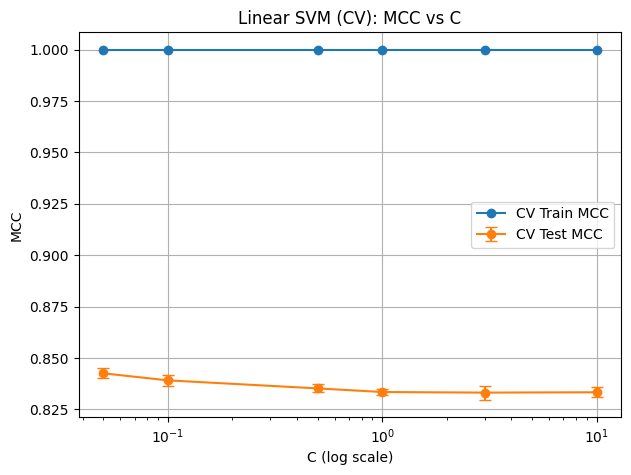

VAL MCC: 0.7583671617081924 , ACCURACY: 0.8392857142857143
TEST MCC: 0.7698531201761091 , ACCURACY: 0.8489813064482251

Test classification report:
                        precision    recall  f1-score   support

Abstract_Expressionism       0.72      0.75      0.73       557
               Baroque       0.81      0.90      0.86       848
                Cubism       0.74      0.77      0.76       447
         Impressionism       0.95      0.89      0.92      2612
               Pop_Art       0.59      0.62      0.61       297

              accuracy                           0.85      4761
             macro avg       0.76      0.79      0.77      4761
          weighted avg       0.85      0.85      0.85      4761


Confusion matrix (test):
[[ 416   11   31   37   62]
 [   7  765    8   56   12]
 [  38   15  345   20   29]
 [  72  136   49 2331   24]
 [  47   14   32   19  185]]


In [ ]:
# hyperparameters for svm grid search
C_GRID = [0.05, 0.1, 0.5, 1, 3, 10]
RANDOM_STATE = 635

# create pipeline for scaling + svm grid
pipe = Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC(class_weight="balanced", dual=False, max_iter=5000, random_state=RANDOM_STATE)),])
param_grid = {
    "svm__C": C_GRID,
    "svm__tol": [1e-3, 1e-4],
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
mcc_scorer = make_scorer(matthews_corrcoef)

gs = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring=mcc_scorer, return_train_score=True, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

# save results to csv
gs_df = pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)
cv_csv = RESULTS_PATH
gs_df.to_csv(cv_csv, index=False)
print("Best parameters:", gs.best_params_, ", Best CV MCC:", gs.best_score_)

# plot scores of different C vals
sub = gs_df.copy()
sub["C"] = sub["param_svm__C"].astype(float)
agg = (sub.groupby("C", as_index=False).agg(mean_test=("mean_test_score","mean"), std_test=("std_test_score","mean"), mean_train=("mean_train_score","mean")))
plt.figure(figsize=(7,5))
plt.plot(agg["C"], agg["mean_train"], marker='o', label='CV Train MCC')
plt.errorbar(agg["C"], agg["mean_test"], yerr=agg["std_test"], marker='o', capsize=4, label='CV Test MCC')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('MCC')
plt.title('Linear SVM (CV): MCC vs C')
plt.grid(True); plt.legend()
plot_path = RESULTS_DIR / "svm_plot.png"
plt.savefig(plot_path, bbox_inches='tight', dpi=150)
plt.show()

# evaluate best kernel value pipeline on test
best_model = gs.best_estimator_
val_pred  = best_model.predict(X_val)
test_pred = best_model.predict(X_test)

# print evaluation metrics
print("VAL MCC:", matthews_corrcoef(y_val,  val_pred), ", ACCURACY:", accuracy_score(y_val,  val_pred))
print("TEST MCC:", matthews_corrcoef(y_test, test_pred), ", ACCURACY:", accuracy_score(y_test, test_pred))
print("\nTest classification report:")
print(classification_report(y_test, test_pred, target_names=TARGET_STYLES))
print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, test_pred))